# Проект для «Викишоп»

**Краткое описание:** Необходимо обучить лучшую модель, которая будет классифицировать комментарии на позитивные и негативные. У меня есть набор данных с разметкой о токсичности правок. 


**План:** 
1. Загружу и подготовлю данные (использую очистку от лишних символов, стоп-слова, проведу леммитизацию). 
2.  Обучу 2 модели на тренировочной выборке с подбором гиперпараметров и посчитаю F1. Он должен получиться не меньше 0.75. 
3. На тестовой выборке проверю модель, показавшую лучшую F1 на трейн.

## Загрузка и изучение данных:

In [1]:
import numpy as np
import pandas as pd

import re

import nltk

from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression, SGDClassifier
from lightgbm import LGBMRegressor

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve

from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
display(data.head())
print()
data.info()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data.duplicated().sum()

0

In [5]:
data.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [6]:
data.toxic.value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

In [7]:
# Столбец Unnamed можно убрать, он не несет функциональную/смысловую нагрузку:
data = data.drop(['Unnamed: 0'], axis=1)

Вывод по исходному датасету: В дф 159292 данных. Пропусков и дубликатов нет. Объектов токсик в 9 раз больше, нужно будет поработать над балансировкой. 

In [8]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


## Подготовка данных.

В подготовке данных нужно леммитизировать текст, избавить его от лишних символов, сбалансировать данные по токсик и нетоксик комментариям. Определим TF-IDF для оценки важности слова. 

In [9]:
def clear_text(text):


    def limit(text):
        #убираем из комментариев слова длиной от 50 до 10000 символов
        #это ограничение необходимо, т.к. есть "слово", ломающее лемматизатор
        lim = re.sub(r'\b\w{50,10000}\b', ' ', text) 
        lim1 = " ".join(lim.split()) #применяем фильтр
        return lim1


    clear = re.sub(r'[^a-zA-Z ]', ' ', limit(text)) #фильтруем латиницу, символы
    clear1 = " ".join(clear.split()) #применяем фильтр
    return clear1

In [10]:
from tqdm import tqdm
tqdm.pandas()

In [11]:
data['text'] = data['text'].progress_apply(clear_text) 

100%|██████████| 159292/159292 [00:04<00:00, 35566.70it/s]


In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [13]:
# Напишу функцию РОS-тэгирования слов:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               
                "N": wordnet.NOUN,              
                "V": wordnet.VERB,              
                "R": wordnet.ADV                
               }  
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

# Напишу функцию для леммитизации:
def lemm_text(text):
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(text)

In [14]:
data['text'] = data['text'].progress_apply(lemm_text) 

100%|██████████| 159292/159292 [17:54<00:00, 148.29it/s]


In [49]:
data.head()

,text,toxic
0,Explanation Why the edits make under my userna...,0
1,D aww He match this background colour I m seem...,0
2,Hey man I m really not try to edit war It s ju...,0
3,More I can t make any real suggestion on impro...,0
4,You sir be my hero Any chance you remember wha...,0


In [50]:
#Выведем соотношение
class_ratio = data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1]

In [52]:
# Разобьем выборку по отношению 50/20/20. Уменьшим количество кроссвалидаций до 3 из-за размера выборки.
target = data['toxic']
features = data.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.5, 
                                                                              random_state=1515)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=1515)

stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['text'])
features_valid = count_tf_idf.transform(features_valid['text'])
features_test = count_tf_idf.transform(features_test['text'])

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts = 2

(79646, 105458)
(39823, 105458)
(39823, 105458)


Выше мы определили, что выборки несбалансированы, поэтому:

#### Балансировка данных

Уменьшение размера весов класса:

In [53]:
dict_classes={0:1, 1:class_ratio}
classificator = LogisticRegression(class_weight=dict_classes)
train_f1_ballanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.7446790811539917


In [54]:
classificator = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.7446790811539917


### Ресемплинг с уменьшением класса 0

In [55]:
toxic_comments_train = data.iloc[target_train.index]

target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

In [56]:
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12082020)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = data.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12082020)
features_train_downsample = count_tf_idf.transform(features_train_downsample['text'])

In [57]:
classificator = LogisticRegression()
train_f1_downsampled = cross_val_score(classificator,
                      features_train_downsample, 
                      target_train_downsample, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV с уменьшением классов', train_f1_downsampled)

F1 на CV с уменьшением классов 0.8750403651451382


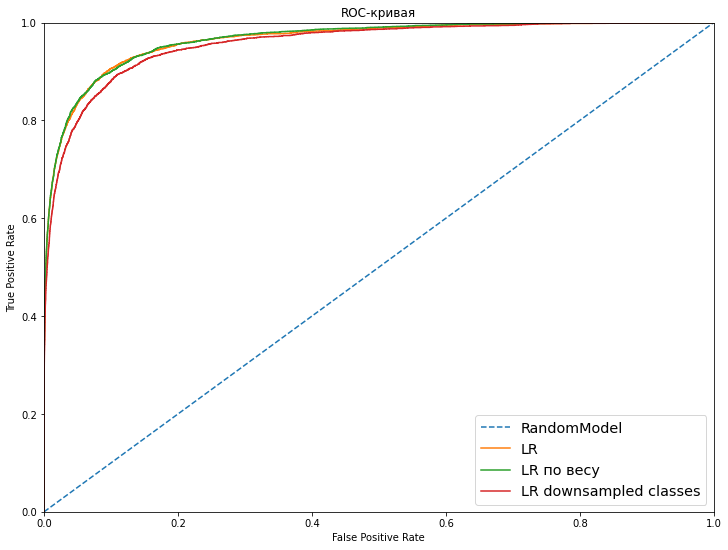

In [58]:
# Построим ROC-AUC графики балансировки
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR')

classificator = LogisticRegression(class_weight=dict_classes)
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR по весу')

classificator = LogisticRegression()
classificator.fit(features_train_downsample,target_train_downsample)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_downsampled = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_downsampled = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR downsampled classes')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

## Обучение

Подберу лучшие гиперпараметры:

In [59]:
classificator = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}

Grid scores on development set:

0.702679 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.702717 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.702673 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'liblinear'}
0.744679 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.744679 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.744636 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'liblinear'}
0.747925 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.747596 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.747878 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver

Обучу модель на тренировочной выборке и проверю на валидационной:

In [62]:
classificator_lr = LogisticRegression()
classificator_lr.set_params(**LR_best_params).fit(features_train, target_train)
classificator_lr.fit(features_train, target_train)
target_predict = classificator_lr.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.7479247904338503
F1 на валидации 0.7502922609305588


In [63]:
classificator = CatBoostClassifier(verbose=False, iterations=110)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
cv_f1_CBC = cross_val_score(classificator,
                                         features_train, 
                                         target_train, 
                                         cv=cv_counts, 
                                         scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

F1 на cv 0.707412419185085
F1 на валидации 0.7257359370445934


## Тестирование:

In [64]:
prediction = classificator_lr.predict(features_test)

In [65]:
# Рассчитаю F1: 
f1_score(target_test, prediction)

0.7563025210084033

## Вывод:
Я загрузила данные, изучив датасет поняла, что данные несбалансированы, но пропусков и дубликатов нет. Приступила к подготовке данных, поняла, что столбец Unnamed бесполезен, поэтому удалила его. Написала функции для удаления лишних символов, леммитизации, сбалансировки, сделала это все. Разделила данные на фичи и таргет. Обучила модели Логистической регресии и катбуст. Лучше себя показала Логистическая регрессия. Проверила обученную модель на тестоой выборке, f1 получился 0.756.